Progetto A1

Antonini Davide 0316030

Addestrare e valutare uno o più modelli di classificazione utilizzando il dataset 'Extended MNIST'
(EMNIST), contenente lettere alfabetiche invece delle cifre.

Qui andiamo ad utilizzare per il problema di classificazione multiclasse una rete
convoluzionale, rete specializzata nelle immagini. Nel particolare utilizziamo una rete LeNet composta da 2 parti:

-un encoder convoluzionale composto da 2 layers convoluzionali

-un blocco denso composto da 3 strati nascosti pienamente connessi (unita: 120-84-10)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Carichiamo il dataset EMNIST, separiamo le features dalle etichette corrispondenti e 
dividiamo il dataset in training_set (80%) e test_set (20%).
Inoltre il dataset fornisce per ogni campione un vettore di 784 elementi, corrispondenti ai pixels, quindi effettuiamo un reshape in immagini 28x28

In [2]:
df = pd.read_csv("emnist-letters.csv") #carica i dati in df

#separa le immagini dalle etichette e effettua reshuaping in 28x28
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F")
y = df.iloc[:,0].to_numpy()-1  # Sottrai 1 per avere etichette da 0 a 25

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2) #random_state=42

print("Done!")

Done!


Il training_set contiene 71039 immagini in scala di grigio, each 28x28 pixels, mentre 
il test_set 17760 immagini in scala di grigio:

In [3]:
#verifiche delle dimensioni
print("Dimensioni X_train_full:", X_train_full.shape)
print("Dimensioni y_train_full:", y_train_full.shape)
print("Dimensioni X_test:", X_test.shape)
print("Dimensioni y_test:", y_test.shape)
print("Done!")

Dimensioni X_train_full: (71040, 28, 28)
Dimensioni y_train_full: (71040,)
Dimensioni X_test: (17760, 28, 28)
Dimensioni y_test: (17760,)
Done!


Ogni pixels è rappresentato come un byte (0 to 255):

I dati sono di tipo int64, cioè interi a 64 bit anche negativi

In [4]:
#meglio trasformali in uint8 perchè piu efficienti in termini di memoria, considerando che non 
#abbiamo bisogno di interi negativi e di questo spazio di memoria occupato
print(X_train_full.dtype) #int64, cioè i dati sono rappresentati come numeri interi a 64 bit
print(y_train_full.dtype)
print(X_test.dtype)
print(y_test.dtype)
print("Done!")

int64
int64
int64
int64
Done!


Converto i dati in uint8 perche hanno un range fino a 255 e non sono negativi,
quindi occupo meno spazio in memoria

In [5]:
X_train_full = X_train_full.astype(np.uint8)
y_train_full = y_train_full.astype(np.uint8)
X_test = X_test.astype(np.uint8)
y_test = y_test.astype(np.uint8)

print(X_train_full.dtype)
print(y_train_full.dtype)
print(X_test.dtype)
print(y_test.dtype)
print("Done!")

uint8
uint8
uint8
uint8
Done!


Dividiamo una parte del traning_set (i primi 5000 campioni) in validation_set e
normalizziamo dividendo per 255 per avere i pixels in un range di 0-1

In [6]:
#utilizziamo i primi 5000 campioni come validation set
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.
print("Done!")

Done!


Le classi del dataset sono le 26 lettere dell'alfabeto:

In [7]:
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P",
              "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z",]
print("Done!")

Done!


Essendo immagini in scala di grigio, hanno un singolo canale:

In [8]:
X_train2 = X_train.reshape(-1, 28, 28, 1) # single channel
X_valid2 = X_valid.reshape(-1, 28, 28, 1)
display(X_train2.shape)

(66040, 28, 28, 1)

Creo la rete LeNet come da architettura:

In [9]:
lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='sigmoid'),
            tf.keras.layers.Dense(84, activation='sigmoid'),
            tf.keras.layers.Dense(26, activation="softmax")])


lenet.compile(loss="sparse_categorical_crossentropy", #funzione di loss
              optimizer="adam", #ottimizzatore
              metrics=["accuracy"]) #metrica

lenet.summary() #visualizzazione della rete



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)              

In [10]:
history = lenet.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Epoch 1/30


2064/2064 [==============================] - 14s 6ms/step - loss: 1.8056 - accuracy: 0.4862 - val_loss: 0.9375 - val_accuracy: 0.7116
Epoch 2/30
2064/2064 [==============================] - 13s 6ms/step - loss: 0.6925 - accuracy: 0.7935 - val_loss: 0.5884 - val_accuracy: 0.8182
Epoch 3/30
2064/2064 [==============================] - 14s 7ms/step - loss: 0.4745 - accuracy: 0.8550 - val_loss: 0.4709 - val_accuracy: 0.8512
Epoch 4/30
2064/2064 [==============================] - 14s 7ms/step - loss: 0.3829 - accuracy: 0.8803 - val_loss: 0.3828 - val_accuracy: 0.8786
Epoch 5/30
2064/2064 [==============================] - 16s 8ms/step - loss: 0.3349 - accuracy: 0.8930 - val_loss: 0.3571 - val_accuracy: 0.8874
Epoch 6/30
2064/2064 [==============================] - 17s 8ms/step - loss: 0.3017 - accuracy: 0.9033 - val_loss: 0.3224 - val_accuracy: 0.8988
Epoch 7/30
2064/2064 [==============================] - 17s 8ms/step - loss: 0.2771 - accuracy: 0.9109 - val_loss: 0.3247 - val_

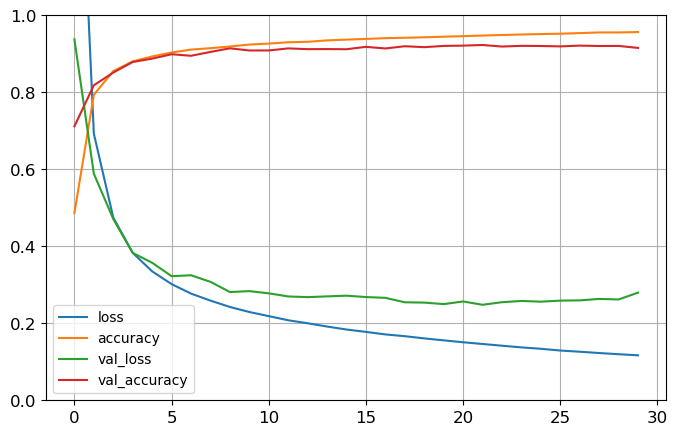

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

valutiamo la rete sul test_set:

In [12]:
X_test2 = X_test.reshape(-1, 28, 28, 1) # single channel
lenet.evaluate(X_test2, y_test)

555/555 [==============================] - 3s 5ms/step - loss: 0.2481 - accuracy: 0.9223


[0.24807535111904144, 0.9222972989082336]

Proviamo ora ad utilizzare la ReLu al posto della sigmoide come funzione di attivazione

In [13]:
lenet_alt = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])

lenet_alt.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history2 = lenet_alt.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Epoch 1/30
2064/2064 [==============================] - 22s 9ms/step - loss: 0.6608 - accuracy: 0.7952 - val_loss: 0.3823 - val_accuracy: 0.8782
Epoch 2/30
2064/2064 [==============================] - 17s 8ms/step - loss: 0.3140 - accuracy: 0.8954 - val_loss: 0.3046 - val_accuracy: 0.8998
Epoch 3/30
2064/2064 [==============================] - 14s 7ms/step - loss: 0.2544 - accuracy: 0.9142 - val_loss: 0.2811 - val_accuracy: 0.9090
Epoch 4/30
2064/2064 [==============================] - 15s 7ms/step - loss: 0.2208 - accuracy: 0.9234 - val_loss: 0.2521 - val_accuracy: 0.9164
Epoch 5/30
2064/2064 [==============================] - 13s 6ms/step - loss: 0.1982 - accuracy: 0.9308 - val_loss: 0.2539 - val_accuracy: 0.9148
Epoch 6/30
2064/2064 [==============================] - 17s 8ms/step - loss: 0.1773 - accuracy: 0.9361 - val_loss: 0.2496 - val_accuracy: 0.9226
Epoch 7/30
2064/2064 [==============================] - 20s 10ms/step - loss: 0.1642 - accuracy: 0.9400 - val_loss: 0.2355 - val_a

Notiamo come l'addestramento si sia fermato prima delle 30 epoche. Questo per la tecnica 
di regolarizzazione earling stopping, un criterio che ferma l'addestramento quando la loss del validation set 
si alza per un numero di volte indicato nel campo patience.

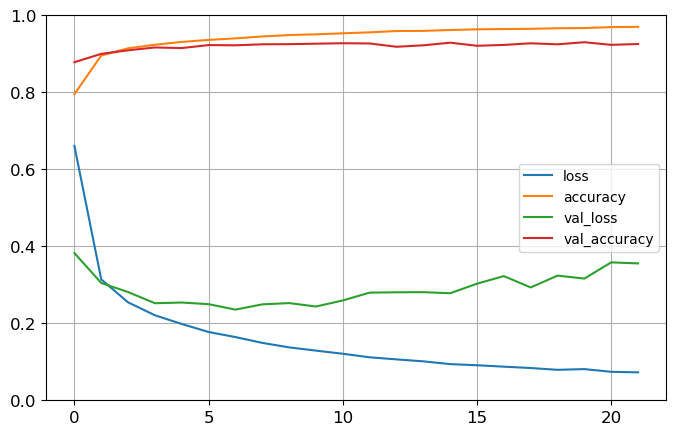

In [14]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Valutazione del modello lenet_alt sul test_set

In [15]:
lenet_alt.evaluate(X_test2, y_test)

555/555 [==============================] - 3s 4ms/step - loss: 0.3258 - accuracy: 0.9289


[0.32582202553749084, 0.9289414286613464]

Utilizziamo ora la rete LeNet con l'algoritmo di ottimizzazione SGD al posto di Adam

In [16]:
lenet_sgd = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])

lenet_sgd.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history3 = lenet_sgd.fit(X_train2, y_train, epochs=30,
                    validation_data=(X_valid2, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Epoch 1/30
2064/2064 [==============================] - 22s 8ms/step - loss: 0.7109 - accuracy: 0.7813 - val_loss: 0.4345 - val_accuracy: 0.8582
Epoch 2/30
2064/2064 [==============================] - 17s 8ms/step - loss: 0.3244 - accuracy: 0.8926 - val_loss: 0.3404 - val_accuracy: 0.8914
Epoch 3/30
2064/2064 [==============================] - 17s 8ms/step - loss: 0.2623 - accuracy: 0.9118 - val_loss: 0.3068 - val_accuracy: 0.9016
Epoch 4/30
2064/2064 [==============================] - 16s 8ms/step - loss: 0.2277 - accuracy: 0.9219 - val_loss: 0.2592 - val_accuracy: 0.9184
Epoch 5/30
2064/2064 [==============================] - 16s 8ms/step - loss: 0.2020 - accuracy: 0.9288 - val_loss: 0.2825 - val_accuracy: 0.9078
Epoch 6/30
2064/2064 [==============================] - 16s 8ms/step - loss: 0.1841 - accuracy: 0.9342 - val_loss: 0.2575 - val_accuracy: 0.9204
Epoch 7/30
2064/2064 [==============================] - 16s 8ms/step - loss: 0.1676 - accuracy: 0.9393 - val_loss: 0.2568 - val_ac

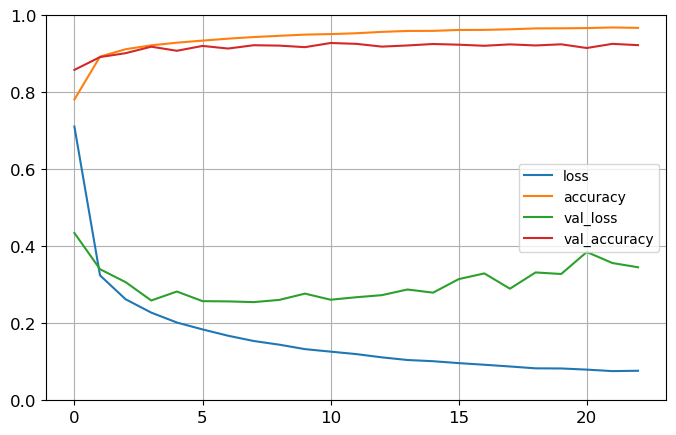

In [17]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Valutazione del modello lenet_alt sul test_set

In [18]:
lenet_sgd.evaluate(X_test2, y_test)

555/555 [==============================] - 3s 5ms/step - loss: 0.3043 - accuracy: 0.9262


[0.3043089210987091, 0.9261824488639832]